# Solving convex hull problem using Pointer Network (Ptr-Net)

This code is a simplified version of the codeincluded in the tutorial: [Pointer Networks with Transformers](https://towardsdatascience.com/pointer-networks-with-transformers-1a01d83f7543) &copy; Mason McGough, 2021.

In [1]:
import math
from pprint import pprint
from typing import Tuple, Union, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely import geometry

%matplotlib inline

### Uncomment in case of using Google colab

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/ptrnets')

### Import the used helper functions

In [3]:
from ptrnets.Data import generate_random_points,display_points,display_points_with_hull,cyclic_permute,Scatter2DDataset
from ptrnets.ptr_net import min_value_of_dtype,masked_log_softmax,masked_max,convert_binary_mask_to_infinity_mask,PointerNetwork,ConvexNet,AverageMeter,masked_accuracy,calculate_hull_overlap
from ptrnets.Disp import Disp_results

### Generate a set of training and validation datasets for training.

In [4]:
min_samples = 5
max_samples = 50
n_rows_train = 100000
n_rows_val = 1000

torch.random.manual_seed(231)
train_dataset = Scatter2DDataset(n_rows_train, min_samples, max_samples)
val_dataset = Scatter2DDataset(n_rows_val, min_samples, max_samples)

print(f'# train: {len(train_dataset):7d}')
print(f'# val:   {len(val_dataset):7d}')

# train:  100000
# val:      1000


### Train the model

Feel free to modify the arguments below to see how they affect the performance and accuracy.

In [6]:
TOKENS = {'<eos>': 0 }  # end-of-sequence token 
c_inputs = 2 + len(TOKENS)
c_embed = 16
c_hidden = 16
n_heads = 4
n_layers = 3
dropout = 0.0
use_cuda = True
n_workers = 2

n_epochs = 10
batch_size = 16
lr = 1e-3
log_interval = 500

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size,
  num_workers=n_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
  num_workers=n_workers)

model = ConvexNet(c_inputs=c_inputs, c_embed=c_embed, n_heads=n_heads,
  n_layers=n_layers, dropout=dropout, c_hidden=c_hidden).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss(ignore_index=TOKENS['<eos>'])

train_loss = AverageMeter()
train_accuracy = AverageMeter()
val_loss = AverageMeter()
val_accuracy = AverageMeter()

# begin training
for epoch in range(n_epochs):
  model.train()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(train_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    optimizer.zero_grad()
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()

    train_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    train_accuracy.update(acc, mask.int().sum().item())

    if bat % log_interval == 0:
      print(f'Epoch {epoch}: '
            f'Train [{bat * len(batch_data):9d}/{len(train_dataset):9d} '
            f'Loss: {train_loss.avg:.6f}\tAccuracy: {train_accuracy.avg:3.4%}')

  model.eval()
  hull_overlaps = []
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(val_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths,
      batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    val_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  print(f'Epoch {epoch}: Val\tLoss: {val_loss.avg:.6f} '
        f'\tAccuracy: {val_accuracy.avg:3.4%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.4%}')
  train_loss.reset()
  train_accuracy.reset()
  val_loss.reset()
  val_accuracy.reset()

Epoch 0: Train [        0/   100000 Loss: 3.562674	Accuracy: 0.0000%
Epoch 0: Train [     8000/   100000 Loss: 1.624308	Accuracy: 57.4176%
Epoch 0: Train [    16000/   100000 Loss: 1.127312	Accuracy: 69.5953%
Epoch 0: Train [    24000/   100000 Loss: 0.897873	Accuracy: 75.1722%
Epoch 0: Train [    32000/   100000 Loss: 0.759142	Accuracy: 78.6432%
Epoch 0: Train [    40000/   100000 Loss: 0.666586	Accuracy: 80.9646%
Epoch 0: Train [    48000/   100000 Loss: 0.600366	Accuracy: 82.6611%
Epoch 0: Train [    56000/   100000 Loss: 0.550527	Accuracy: 83.9364%
Epoch 0: Train [    64000/   100000 Loss: 0.509580	Accuracy: 84.9920%
Epoch 0: Train [    72000/   100000 Loss: 0.477010	Accuracy: 85.8348%
Epoch 0: Train [    80000/   100000 Loss: 0.450015	Accuracy: 86.5183%
Epoch 0: Train [    88000/   100000 Loss: 0.427836	Accuracy: 87.0755%
Epoch 0: Train [    96000/   100000 Loss: 0.407568	Accuracy: 87.6105%
Epoch 0: Val	Loss: 0.179186 	Accuracy: 93.4841% 	Overlap: 78.7282%
Epoch 1: Train [        

### Save the trained model

In [ ]:
# PATH='/ptrnets'
# torch.save(model.state_dict(), PATH)

### Display the results in terms of training and validation losses and accuracies

Best Scores:
train_loss: 0.0897 (ep: 9)
train_accuracy 96.61% (ep: 9)
val_loss: 0.0937 (ep: 7)
val_accuracy: 96.54% (ep: 7)


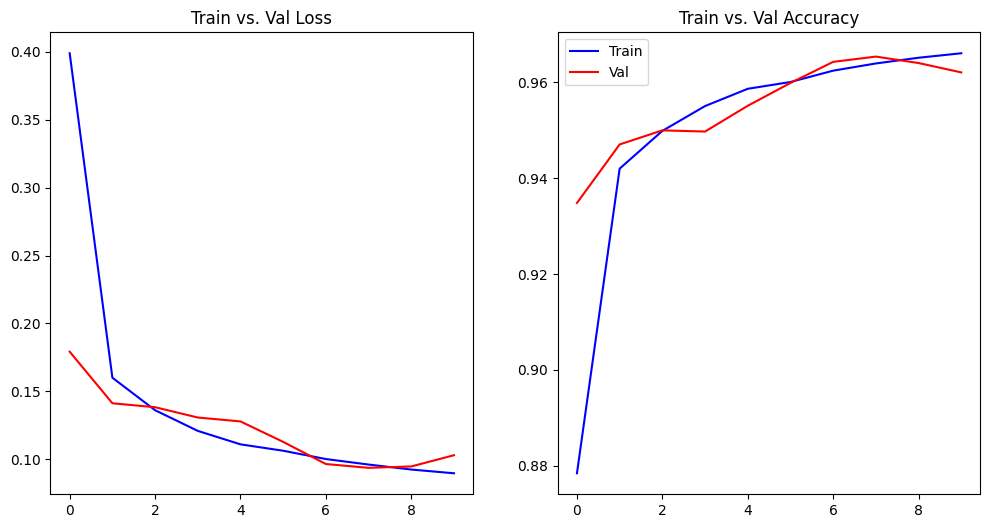

In [8]:
Disp_results(train_loss,train_accuracy,val_loss,val_accuracy,n_epochs)

### Evaluate the trained model on testing set

Generate a testing dataset to evaluate the performance of our trained model. Note that the testing accuracy is lower than the validation accuracy displayed above. This is because training and validation both use teacher forcing to produce training labels, whereas testing does not.

In [9]:
n_rows_test = 1000

def test(model, n_rows_test, n_per_row):
  test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
  test_loader = DataLoader(test_dataset, batch_size=batch_size,
    num_workers=n_workers)

  test_accuracy = AverageMeter()
  hull_overlaps = []
  model.eval()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(test_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths)

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    test_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  print(f'# Test Samples: {n_per_row:3d}\t '
        f'\tAccuracy: {test_accuracy.avg:3.1%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.1%}')

for i in range(5,50,5):
  test(model, n_rows_test, i)

# Test Samples:   5	 	Accuracy: 54.8% 	Overlap: 43.7%
# Test Samples:  10	 	Accuracy: 72.1% 	Overlap: 79.1%
# Test Samples:  15	 	Accuracy: 79.0% 	Overlap: 90.1%
# Test Samples:  20	 	Accuracy: 84.8% 	Overlap: 92.7%
# Test Samples:  25	 	Accuracy: 80.6% 	Overlap: 92.3%
# Test Samples:  30	 	Accuracy: 80.3% 	Overlap: 91.6%
# Test Samples:  35	 	Accuracy: 77.8% 	Overlap: 91.9%
# Test Samples:  40	 	Accuracy: 75.8% 	Overlap: 92.1%
# Test Samples:  45	 	Accuracy: 72.4% 	Overlap: 90.4%


### Display an example prediction

Generate and visualize an example convex hull with our model.

In [13]:
idx = 0
n_per_row = 50

test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
  num_workers=n_workers)
batch_data, batch_labels, batch_lengths = next(iter(test_loader))
print(batch_data.shape,batch_lengths.shape)
log_pointer_scores, pointer_argmaxs = model(batch_data.to(device),
  batch_lengths.to(device))
pred_hull_idxs = pointer_argmaxs[idx].cpu()
pred_hull_idxs = pred_hull_idxs[pred_hull_idxs > 1] - 2
points = batch_data[idx, 2:batch_lengths[idx], :2]
points1 = batch_data[idx, 1:batch_lengths[idx], :2]
print(points.shape,)
true_hull_idxs = ConvexHull(points).vertices.tolist()
true_hull_idxs = cyclic_permute(true_hull_idxs, np.argmin(true_hull_idxs))

overlap = calculate_hull_overlap(batch_data[idx].cpu(), batch_lengths[idx].cpu(),
  pointer_argmaxs[idx].cpu())

print(f'Predicted: {pred_hull_idxs.tolist()}')
print(f'True:      {true_hull_idxs}')
print(f'Hull overlap: {overlap:3.2%}')

torch.Size([16, 51, 3]) torch.Size([16])
torch.Size([49, 2])
Predicted: [3, 9, 12, 46, 48, 40, 37, 7, 0]
True:      [0, 3, 9, 12, 46, 47, 48, 40, 37, 7]
Hull overlap: 99.95%


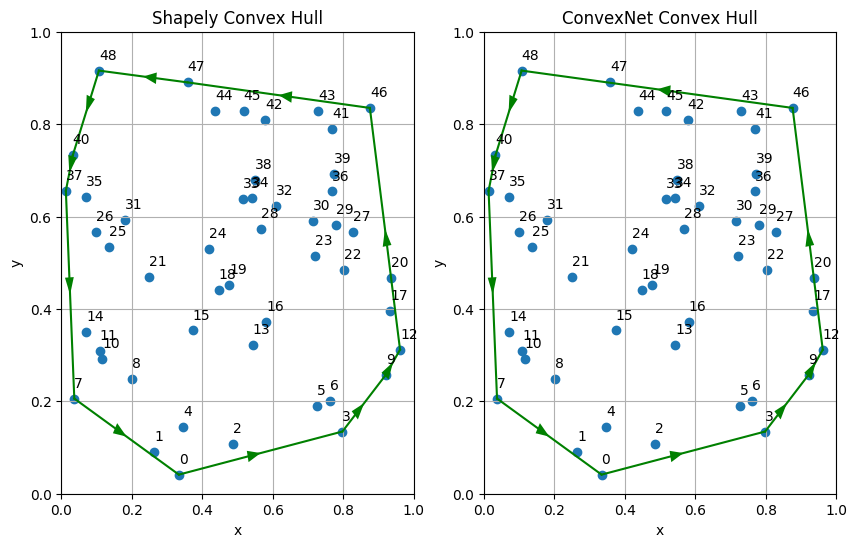

In [14]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.subplot(1, 2, 1)
true_hull_idxs = ConvexHull(points).vertices.tolist()
display_points_with_hull(points, true_hull_idxs)
_ = plt.title('Shapely Convex Hull')

plt.subplot(1, 2, 2)
display_points_with_hull(points, pred_hull_idxs)
_ = plt.title('ConvexNet Convex Hull')
# plt.savefig('ConvexNet.png', dpi=600)